## Reproduction of the UniformatBridge model implementation

- This is an **_unofficial_** reproduction of the experiment described in "Transformer language model for mapping construction schedule activities to uniformat categories" by Yoonhwa Jung, Julia Hockenmaier, and Mani Golparvar-Fard, 2024.
- The study can be accessed at https://doi.org/10.1016/j.autcon.2023.105183.

In [1]:
import time; start_time = time.time()

In [2]:
!python -V

Python 3.11.6


In [29]:
# Experimental Settings from Jung et al. (2024)
# 6p: "Five epochs with a batch size of 32, a dropout rate of 0.1, and a learning rate of 1.5e−5 were used to fine-tune the model."
epoch_size = 1
batch_size = 32
dropout_rate = 0.1  # BertForSequenceClassification default dropout_rate = 0.1
learning_rate = 1.5e-5

# 7p: "In Table 2 and 3, 𝜇 is the average performance on three random seeds, and 𝜎 is their standard deviation."
rseed = 42

In [4]:
experiment_name = 'simple_balancing'  # for writing output file names.

experiment_setting = {
    'rseed': rseed, 
    'simple_balancing': False    
}

import json
with open(f'experimental_results/{experiment_name}_experiment_setting.json', 'w') as json_file:
    json.dump(experiment_setting, json_file, indent=4, sort_keys=True)

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data

#### BIM and ASTM Uniformat categories

In [6]:
import pandas as pd
dataset_path = "E:/_datasets/jung_et_al_2024/"  # Data should not be shared publicly.
df = pd.read_excel(dataset_path+"0-overall-level3.xlsx", header=0)

cls = 'Level3'
df = df.loc[:, ['predwbs2', 'predwbs', 'predtask', 'wbs2', 'wbs', 'name', 'sucwbs2', 'sucwbs', 'suctask', cls]]

In [7]:
new_tokens = ['[pred]', '[succ]']

df['text'] = df.apply(
    lambda row: f"{row['predwbs2']} > {row['predwbs']} > {row['predtask']} [pred] {row['wbs2']} > {row['wbs']} > {row['name']} [succ] {row['sucwbs2']} > {row['sucwbs']} > {row['suctask']}",
    axis=1
)
df['label'] = df[cls]
label_cnt = df['label'].value_counts()

print_idx = 6538  # D2040: 'Rain Water Drainage' case in Table 4
print('text: ', df['text'][print_idx])
print('label: ', df['label'][print_idx])

text:  CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mechanical Equipment [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Pipe Mechanical Equipment [succ]  100 KINGSHIGHWAY > COMMISSIONNG & INSPECTIONS > STARTUP
label:  D2040


In [8]:
from sklearn.model_selection import train_test_split

texts = df['text']
labels = df['label']

# 6p: "This dataset is further split into training, validation, and testing using a 60-20-20 distribution."
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.4, random_state=rseed)
validation_texts, test_texts, validation_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=rseed)

(len(train_texts), len(validation_texts), len(test_texts))

(20469, 6823, 6824)

#### ★ Additional Experiment: What if we simply duplicate scarce data for data balancing?

In [9]:
if experiment_setting['simple_balancing']:
    label_counts = train_labels.value_counts()

    # Set the frequency of the most frequent label as the target for all labels
    max_count = label_counts.max()

    train_texts_balanced = []
    train_labels_balanced = []
    for label, count in label_counts.items():
        # Calculate how many times to duplicate based on the target frequency
        factor = max_count // count
        remainder = max_count % count
        
        # Select texts corresponding to the current label
        texts_of_label = train_texts[train_labels == label]
        
        # Duplicate texts to match the target frequency
        for _ in range(factor):
            train_texts_balanced.extend(texts_of_label)
            train_labels_balanced.extend([label] * len(texts_of_label))
        
        if remainder > 0:
            train_texts_balanced.extend(texts_of_label[:remainder])
            train_labels_balanced.extend([label] * remainder)

    train_texts = pd.Series(train_texts_balanced)
    train_labels = pd.Series(train_labels_balanced)

    print(train_labels.value_counts()[:5])

#### Label Encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(labels)

train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

#### Text Encoding

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_)).to(device)

tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

tokenizer, model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	30522: AddedToken("[pred]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
 	30523: AddedTo

#### Make DataLoader

In [12]:
from torch.utils.data import TensorDataset, DataLoader

def make_dataloader(plain_texts, encoded_labels, batch_size=32):
    '''
    plain_texts: list of strings (should be encoded when making dataloader due to tokenizer padding/truncation)
    encoded_labels: list of class indices (should be encoded beforehand using LabelEncoder with the entire dataset)
    '''
    texts = tokenizer(plain_texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
    labels = torch.tensor(encoded_labels, dtype=torch.long).to(device)
    dataset = TensorDataset(
        texts['input_ids'], 
        texts['attention_mask'], 
        labels,
    )
    return DataLoader(dataset, batch_size=batch_size)

train_loader = make_dataloader(train_texts.tolist(), train_labels_encoded, batch_size)
validation_loader = make_dataloader(validation_texts.tolist(), validation_labels_encoded, batch_size)
test_loader = make_dataloader(test_texts.tolist(), test_labels_encoded, batch_size)

len(train_loader), len(validation_loader), len(test_loader)

(640, 214, 214)

#### ★ Additional Datasets: ASTM Uniformat II Classification for Building Elements Description

In [13]:
import pandas as pd

# Publicly available definition of ASTM Uniformat II
# https://www.govinfo.gov/content/pkg/GOVPUB-C13-5af96252bc88826c911daac93c449927/pdf/GOVPUB-C13-5af96252bc88826c911daac93c449927.pdf
df_astm = pd.read_csv("public_astm_uniformat_ii_classification.csv", header=0)

df_astm = df_astm[df_astm['Class'].isin(label_encoder.classes_)] # Use only the classes that are in the dataset
df_astm

,Level1,Level2,Level3,Class
0,SUBSTRUCTURE,Foundations,Standard Foundations,A1010
1,SUBSTRUCTURE,Foundations,Special Foundations,A1020
2,SUBSTRUCTURE,Foundations,Slab on Grade,A1030
3,SHELL,Superstructure,Floor Construction,B1010
4,SHELL,Superstructure,Roof Construction,B1020
5,SHELL,Exterior Enclosure,Exterior Walls,B2010
6,SHELL,Exterior Enclosure,Exterior Windows,B2020
7,SHELL,Exterior Enclosure,Exterior Doors,B2030
8,SHELL,Roofing,Roof Coverings,B3010
9,SHELL,Roofing,Roof Openings,B3020


#### ★ Additional Datasets: Data augmentation with GPT-2

In [14]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed

set_seed(42)

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

def generate_sentences_with_gpt2(prompt_text, max_len=100, num_sentences=3):
    inputs = gpt2_tokenizer.encode(prompt_text, return_tensors='pt')
    outputs = gpt2_model.generate(
        inputs, 
        pad_token_id=gpt2_tokenizer.eos_token_id, 
        max_length=max_len, 
        # do_sample=True, temperature=0.7, num_return_sequences=num_sentences,
        repetition_penalty=1.2,
    )
    if len(outputs) == 1: # Deterministic
        generated_text = [gpt2_tokenizer.decode(outputs[0])] * num_sentences
    else:
        generated_text = [gpt2_tokenizer.decode(output) for output in outputs]

    return generated_text

generate_sentences_with_gpt2("Once upon a time,")

['Once upon a time, the world was filled with people who were not only rich but also powerful.\nThe first thing that came to mind when I thought of this is how much money they had in their pockets and what kind it would be if someone took them out on an adventure or something like those things? The amount you could spend at any given moment without having anyone else\'s attention! It seemed so simple for me… But then again maybe there are some more interesting ways around these kinds "money',
 'Once upon a time, the world was filled with people who were not only rich but also powerful.\nThe first thing that came to mind when I thought of this is how much money they had in their pockets and what kind it would be if someone took them out on an adventure or something like those things? The amount you could spend at any given moment without having anyone else\'s attention! It seemed so simple for me… But then again maybe there are some more interesting ways around these kinds "money',
 'On

In [15]:
# Intuition
level1 = 'SERVICES'
level2 = 'plumbing'
level3 = 'Rain Water Drainage'
generate_sentences_with_gpt2(f"Examples of building structure components for {level1.lower()} of {level2.lower()} and {level3.lower()} are")

['Examples of building structure components for services of plumbing and rain water drainage are:\n.. The main body is a single-layer concrete block with an outer layer that contains the roof, flooring (including insulation), walls, floors, ceilings; it also includes two or more layers in which there may be multiple columns to support each other on top of one another as well ; this can include any number between 1/2" thick at its base, 2\' wide by 3\' high above ground level',
 'Examples of building structure components for services of plumbing and rain water drainage are:\n.. The main body is a single-layer concrete block with an outer layer that contains the roof, flooring (including insulation), walls, floors, ceilings; it also includes two or more layers in which there may be multiple columns to support each other on top of one another as well ; this can include any number between 1/2" thick at its base, 2\' wide by 3\' high above ground level',
 'Examples of building structure com

In [16]:
def generate_with_gpt2_for_astm(level1, level2, level3):
    prompt = f"Examples of building structure components for {level1.lower()} of {level2.lower()} and {level3.lower()} are"
    return [level1 + " " + level2 + " " + level3 + " " +  repr(str[len(prompt):]) for str in generate_sentences_with_gpt2(prompt)]

generate_with_gpt2_for_astm("SERVICES", "Plumbing", "Rain Water Drainage")  # D2040 in ASTM Uniformat

['SERVICES Plumbing Rain Water Drainage \':\\n.. The main body is a single-layer concrete block with an outer layer that contains the roof, flooring (including insulation), walls, floors, ceilings; it also includes two or more layers in which there may be multiple columns to support each other on top of one another as well ; this can include any number between 1/2" thick at its base, 2\\\' wide by 3\\\' high above ground level\'',
 'SERVICES Plumbing Rain Water Drainage \':\\n.. The main body is a single-layer concrete block with an outer layer that contains the roof, flooring (including insulation), walls, floors, ceilings; it also includes two or more layers in which there may be multiple columns to support each other on top of one another as well ; this can include any number between 1/2" thick at its base, 2\\\' wide by 3\\\' high above ground level\'',
 'SERVICES Plumbing Rain Water Drainage \':\\n.. The main body is a single-layer concrete block with an outer layer that contains 

In [17]:
# # astm_texts = df_astm.apply(
# #     lambda row: f"[pred] {generate_with_gpt2_for_astm(row['Level1'], row['Level2'], row['Level3'])} [succ]",
# #     axis=1
# # )

#### ★ New Train DataLoader for Fine-tuning with ASTM Uniformat Class Definition Data

In [18]:
import itertools

train_loader = make_dataloader(
    list(itertools.chain(
        train_texts,
        # astm_texts,
    )),
    list(itertools.chain(
        train_labels_encoded,
        # astm_labels_encoded,
    )),
    batch_size
)

len(train_loader)

640

### Fine-tuning (Train & Validation)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

100%|██████████| 640/640 [02:09<00:00,  4.96it/s]


Epoch 1 | Train Loss: 1.7953308848664165 | Validation Loss: 0.6233449844277907


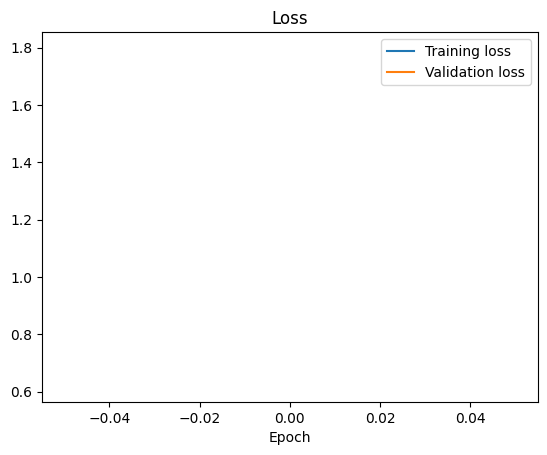

In [20]:
from tqdm import tqdm

train_losses = []
val_losses = []
for epoch in range(epoch_size):
    model.train()
    train_loss = 0
    for input_ids, attention_mask, labels in tqdm(train_loader):
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for input_ids, attention_mask, labels in validation_loader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            val_loss += loss.item()
    val_losses.append(val_loss / len(validation_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]} | Validation Loss: {val_losses[-1]}")

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

### Test

In [21]:
model.eval()
with torch.no_grad():
    true_labels = []
    pred_labels = []
    df_test_rows = []
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for b in range(input_ids.shape[0]):
            text = tokenizer.decode([token for i, token in enumerate(input_ids[b]) if attention_mask[b][i] == 1])
            pred_label = label_encoder.classes_[torch.argmax(outputs.logits[b]).item()]
            true_label = label_encoder.classes_[labels[b].item()]
            df_test_rows.append({'text': text, 'true_label': true_label, 'pred_label': pred_label, 'correct': pred_label == true_label})

# Data should not be shared publicly.
pd.DataFrame(df_test_rows).to_csv(dataset_path+f"/test_results_{experiment_name}.csv")

### Experimental Results

#### Overall Results

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, 
    pred_labels, 
    # average='weighted', 
    average='macro',  # Original paper setting (page 8)
    zero_division=0
)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.8977
Precision: 0.5916
Recall: 0.5135
F1 Score: 0.5125


#### Class-wise Results

In [30]:
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None, zero_division=0)

class_names = label_encoder.inverse_transform(list(set(true_labels)))

performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})
performance_df.to_csv(f'experimental_results/{experiment_name}_precision_recall_fscore_rseed{rseed}.csv')
performance_df

,Class,Precision,Recall,F1 Score
0,A1010,1.000000,0.597015,0.747664
1,A1020,0.522936,0.934426,0.670588
2,A1030,0.804348,0.521127,0.632479
3,A2010,0.977778,0.594595,0.739496
4,A2020,0.000000,0.000000,0.000000
5,B1010,0.952562,0.997021,0.974284
6,B1020,0.668605,0.877863,0.759076
7,B2010,0.963028,0.989150,0.975914
8,B2020,0.964392,0.996933,0.980392
9,B2030,0.000000,0.000000,0.000000


In [31]:
# Scarce labels (less than 10)
performance_df['Total Sample Size'] = label_cnt[performance_df['Class']].values
performance_df[performance_df['Total Sample Size'] < 10]  # only when F1 Score can be calculated

,Class,Precision,Recall,F1 Score,Total Sample Size
11,B3020,0.0,0.0,0.0,6
26,D2040,0.0,0.0,0.0,2
27,D2090,0.0,0.0,0.0,5
45,E1030,0.0,0.0,0.0,3


In [32]:
print('Elapsed time: ', (time.time() - start_time)/60, ' minutes')

Elapsed time:  9.089889029661814  minutes
